In [175]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, List, Tuple, Dict, Optional, Union
from itertools import islice

import qube
%qubed

%load_ext autoreload
%autoreload 2

from qube.core.series import TimeSeries, OHLCV, time_as_nsec, Quote, Trade
from qube.data.readers import (
    CsvDataReader, QuotesDataProcessor, OhlcvDataProcessor, QuotesFromOHLCVDataProcessor, 
    OhlcvPandasDataProcessor, STOCK_DAILY_SESSION
)
from qube.ta.indicators import (sma, ema, tema, dema, kama, highest, lowest)
from qube.utils.pandas import scols
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from qube.core.series import TimeSeries; from qube.ta.indicators import sma; del sys.modules['qube.core.series']; del sys.modules['qube.ta.indicators']
from qube.core.series import TimeSeries, OHLCV, time_as_nsec, Quote, Trade
from qube.ta.indicators import (sma, ema, tema, dema, kama, highest, lowest)

# Common design

## Standard CSV readers

Takes too much time for loading big data

In [10]:
r0 = CsvDataReader('../tests/data/csv/quotes.csv', QuotesDataProcessor())
# r0.read()

In [11]:
qts= r0.read('2017-08-24 13:09:29')

In [6]:
qts[-1].ask == 9.39

True

In [5]:
T = lambda t: np.datetime64(t, 'ns')
# r0.read()

In [133]:
r1 = CsvDataReader('../tests/data/csv/BTCUSDT_ohlcv_M1.csv.gz', OhlcvDataProcessor('test0'))
r2 = CsvDataReader('../tests/data/csv/BTCUSDT_ohlcv_M1_sec.csv.gz', OhlcvDataProcessor('test1'))
r2x = CsvDataReader('../tests/data/csv/BTCUSDT_ohlcv_M1_sec.csv.gz', QuotesFromOHLCVDataProcessor(trades=1))
r3 = CsvDataReader('../tests/data/csv/AAPL.csv', OhlcvDataProcessor('AAPL'), timestamp_parsers=["%m/%d/%Y", "%d-%m-%Y"])
r4 = CsvDataReader('../tests/data/csv/SPY.csv', OhlcvDataProcessor('SPY'), timestamp_parsers=["%Y-%m-%d"])
# r5 = CsvDataReader('../../BTCUSDT_ohlcv_M1.csv.gz', OhlcvDataProcessor('TestBig'))
r4x = CsvDataReader('../tests/data/csv/SPY.csv', QuotesFromOHLCVDataProcessor(
    trades=1,
    daily_session_start_end=STOCK_DAILY_SESSION
), timestamp_parsers=["%Y-%m-%d"])

In [134]:
%%time
# data = r1.read('2024-01-08 11:05:00', '2024-01-08 11:10:00')
# d4 = r4.read('2000-01-01 11:12:34')

# data = r1.read('2024-01-08', '2024-01-08 00:59')
# data = r1.read('2021-01-01', '2000-05-01')
# data = r1.read('2021-01-01', '2000-05-01')
# data = r5.read()
# q_data = r4x.read()
# s_data = r4.read()
q_data = r2x.read()
s_data = r2.read()

CPU times: total: 1.58 s
Wall time: 2.8 s


In [143]:
s2 = OHLCV('Test1', '1Min')
for q in q_data:
    if isinstance(q, Trade):
        s2.update(q.time, q.price, q.size)
    else:
        s2.update(q.time, q.mid_price())
    # break

In [151]:
all((s2.pd() - s_data.pd()) < 1e-5)

True

In [145]:
s_data.pd()

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641
2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444
2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521
2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238
2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366
...,...,...,...,...,...
2024-02-15 06:13:00,51956.3,51977.9,51956.3,51977.2,86.380
2024-02-15 06:14:00,51977.8,51984.9,51961.5,51983.3,271.145
2024-02-15 06:15:00,51983.3,52015.0,51983.2,51995.9,191.007


In [12]:
# np.datetime64(data.times[0], 'ns') == np.datetime64('2024-01-08T11:10:00.000000000')

In [14]:
print(str(data))

TestBig[1Min] | 2333540 records
  2024-02-15T06:17:00.000000000 {o:51965.900000 | h:52004.700000 | l:51950.000000 | c:51950.400000 | v:223.358000}
  2024-02-15T06:16:00.000000000 {o:51996.000000 | h:52014.700000 | l:51965.900000 | c:51966.000000 | v:261.885000}
  2024-02-15T06:15:00.000000000 {o:51983.300000 | h:52015.000000 | l:51983.200000 | c:51995.900000 | v:191.007000}
   .......... 
  2019-09-08T17:59:00.000000000 {o:10000.000000 | h:10000.000000 | l:10000.000000 | c:10000.000000 | v:0.001000}
  2019-09-08T17:58:00.000000000 {o:10000.000000 | h:10000.000000 | l:10000.000000 | c:10000.000000 | v:0.000000}
  2019-09-08T17:57:00.000000000 {o:10000.000000 | h:10000.000000 | l:10000.000000 | c:10000.000000 | v:0.001000}



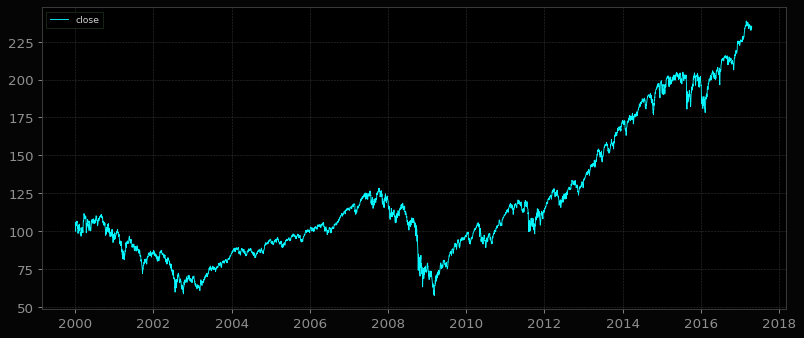

In [17]:
d4.close.plot()

In [49]:
# %%time
# dx0 = pd.read_csv('data/BTCUSDT_ohlcv_M1.csv', parse_dates=True, index_col=['time'], engine="pyarrow")

CPU times: total: 0 ns
Wall time: 17.6 ms


In [158]:
from pyarrow import csv
import pyarrow as pa
table = csv.read_csv(
    # 'data/BTCUSDT_ohlcv_M1_sec.csv', 
    # 'data/BTCUSDT_ohlcv_M1.csv.gz', 
    # 'data/AAPL.csv', 
    'data/SPY1.csv', 
    # 'data/quotes.csv', 
    # parse_options=csv.ParseOptions(ignore_empty_lines=True),
    convert_options=csv.ConvertOptions(
        # timestamp_parsers=["%d-%m-%Y"]
        timestamp_parsers=["%Y-%m-%d"]
    )
)
table

pyarrow.Table
Date: date32[day]
open: double
high: double
low: double
close: double
volume: double
----
Date: [[2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,...,2000-01-10,2000-01-11,2000-01-12,2000-01-13,2000-01-14]]
open: [[107.404545309841,103.98585949558047,101.38228283794643,101.15588287295826,101.65396389794167,...,105.95558,105.63861840614187,104.75562164474871,104.66506129621452,106.15930686485927]]
high: [[107.404545309841,104.37077420169946,102.53689364411323,102.51428774591652,105.59333799999999,...,106.43098837892867,105.84234580983004,104.75562164474871,105.5933379448276,106.83850929730367]]
low: [[104.23493393897722,101.1671802569384,99.43523586964287,99.797478,101.47284324957117,...,105.07258350713381,103.9632524048443,103.51045051376147,103.80473821690417,105.75178540539264]]
close: [[105.36693799999999,101.246443,101.427563,99.797478,105.59333799999999,...,105.95558,104.687735,103.646291,105.049976,106.47626799999999]]
volume: [[8164300,8089800,12177900,62272

In [190]:
# table[0].chunk(0).index(np.datetime64('2020-01-07', 's'))
table[0].cast(pa.timestamp('ms')).index(np.datetime64('2000-01-07', 'ms'))

<pyarrow.Int64Scalar: 4>

In [193]:
f = table.field(0)
# f.type == pa.timestamp('ns')
f.type == pa.timestamp('s')

False

In [ ]:
n_chunks = table[table.column_names[0]].num_chunks

for n in range(n_chunks):
    print(n)
    [table[k].chunk(n).to_numpy() for k in range(table.num_columns)]

In [155]:
table[0].chunk(0).cast(pa.timestamp('ms')).to_numpy()#(zero_copy_only=False)

array(['2000-01-03T00:00:00.000', '2000-01-04T00:00:00.000', '2000-01-05T00:00:00.000', '2000-01-06T00:00:00.000', '2000-01-07T00:00:00.000', '2000-01-08T00:00:00.000', '2000-01-09T00:00:00.000', '2000-01-10T00:00:00.000',
       '2000-01-11T00:00:00.000', '2000-01-12T00:00:00.000', '2000-01-13T00:00:00.000', '2000-01-14T00:00:00.000'], dtype='datetime64[ms]')

In [55]:
ti = table['time']
table

pyarrow.Table
time: timestamp[ns]
open: double
high: double
low: double
close: double
volume: double
----
time: [[2024-01-01 00:00:00.000000000,2024-01-01 00:01:00.000000000,2024-01-01 00:02:00.000000000,2024-01-01 00:03:00.000000000,2024-01-01 00:04:00.000000000,...,2024-01-12 10:56:00.000000000,2024-01-12 10:57:00.000000000,2024-01-12 10:58:00.000000000,2024-01-12 10:59:00.000000000,2024-01-12 11:00:00.000000000],[2024-01-12 11:01:00.000000000,2024-01-12 11:02:00.000000000,2024-01-12 11:03:00.000000000,2024-01-12 11:04:00.000000000,2024-01-12 11:05:00.000000000,...,2024-01-23 22:39:00.000000000,2024-01-23 22:40:00.000000000,2024-01-23 22:41:00.000000000,2024-01-23 22:42:00.000000000,2024-01-23 22:43:00.000000000],[2024-01-23 22:44:00.000000000,2024-01-23 22:45:00.000000000,2024-01-23 22:46:00.000000000,2024-01-23 22:47:00.000000000,2024-01-23 22:48:00.000000000,...,2024-02-04 10:39:00.000000000,2024-02-04 10:40:00.000000000,2024-02-04 10:41:00.000000000,2024-02-04 10:42:00.000000000,

In [56]:
table[table.column_names[0]].num_chunks

4

In [72]:
# s0 = ti.index(time_as_nsec('2024-01-24 13:05:00'))
s1 = ti.index(time_as_nsec('2024-02-08 18:05:00'))
s1
# print(s0, s1.as_py() - s0.as_py())

<pyarrow.Int64Scalar: -1>

In [101]:
for c in ti.iterchunks():
    a = c.to_numpy()
    ix = np.searchsorted(a, time_as_nsec('2024-02-08 10:01:01'))
    if ix < len(c):
        print(a[ix])
        break

2024-02-08T10:02:00.000000000


In [ ]:
ti

In [93]:
np.searchsorted(c.to_numpy(), time_as_nsec('2024-01-12 10:01'))

16441

In [57]:
selected_table = table.slice(s0.as_py(), s1.as_py() - s0.as_py())

In [61]:
n_chunks = selected_table[table.column_names[0]].num_chunks
n_chunks

for n in range(n_chunks):
    data = [selected_table[k].chunk(n).to_numpy() for k in range(selected_table.num_columns)]
    print(data[0][0])
    # break

2024-01-08T11:05:00.000000000
2024-01-12T11:01:00.000000000
2024-01-23T22:44:00.000000000
2024-02-04T10:44:00.000000000


In [ ]:
data

### Fast OHLC series creation

In [ ]:
s = OHLCV('Test1', '1Min')
s.from_data()

In [ ]:
# tt = dx0.index.map(lambda x: x.asm8.item())
# s.open.times.set_values(list(tt))
# s.open.values.set_values(list(dx0.open.values))

# s.high.values.set_values(list(dx0.high.values))
# s.high.times.set_values(list(tt))

# s.low.values.set_values(list(dx0.low.values))
# s.low.times.set_values(list(tt))

# s.close.values.set_values(list(dx0.close.values))
# s.close.times.set_values(list(tt))

# s.volume.values.set_values(list(dx0.volume.values))
# s.volume.times.set_values(list(tt))

# s.times.set_values(list(tt))

### Pandas OHLC data loader

In [425]:
# p1 = CsvDataReader('../tests/data/csv/BTCUSDT_ohlcv_M1.csv.gz', OhlcvPandasDataProcessor())
p2 = CsvDataReader('../../BTCUSDT_ohlcv_M1.csv.gz', OhlcvPandasDataProcessor())

In [434]:
%%time
fx = p2.read('2022-02-01', '1d')

CPU times: total: 422 ms
Wall time: 833 ms


In [435]:
fx

,open,high,low,close,volume
2022-02-01 00:00:00,38439.04,38442.44,38377.55,38377.56,257.709
2022-02-01 00:01:00,38377.56,38377.57,38289.35,38289.35,486.257
2022-02-01 00:02:00,38289.35,38347.09,38269.88,38339.68,475.862
2022-02-01 00:03:00,38339.68,38424.11,38335.01,38393.83,339.537
2022-02-01 00:04:00,38394.99,38413.52,38386.88,38411.11,60.260
...,...,...,...,...,...
2024-02-15 06:13:00,51956.30,51977.90,51956.30,51977.20,86.380
2024-02-15 06:14:00,51977.80,51984.90,51961.50,51983.30,271.145
2024-02-15 06:15:00,51983.30,52015.00,51983.20,51995.90,191.007
2024-02-15 06:16:00,51996.00,52014.70,51965.90,51966.00,261.885


In [165]:
pd.DataFrame({'x': [1,2,3], 'y': [11,22,33]}, index=[0,1,2])

,x,y
0,1,11
1,2,22
2,3,33


In [173]:
f = pd.concat((f, pd.DataFrame({'x': [1,2,3], 'y': [11,22,33]})), copy=False)

In [174]:
f

,x,y
0,1,11
1,2,22
2,3,33
0,1,11
1,2,22
2,3,33
0,1,11
1,2,22
2,3,33
0,1,11


## High level loader design

In [ ]:
class Loader:
    def symbols(self) -> list:
        pass

    def timerange(self) -> tuple:
        pass

    def timeframes(self) -> list:
        pass

    def ohlc(self, timeframe: str, start=None, end=None) -> list:
        pass

    def quotes(self):
        pass

    def trades(self):
        pass

# KDB

# Misc utils tests

In [ ]:
from itertools import islice

def chunked_iterable(iterable, chunk_size):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, chunk_size))
        if not chunk:
            break
        yield chunk

In [ ]:
for p in chunked_iterable(np.arange(1,100), 10):
    print(p)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
[71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[91, 92, 93, 94, 95, 96, 97, 98, 99]


In [ ]:
def csv_fast_detect_number_of_lines(file):
    chunk = 1024 * 1024 * 512 # Process 500 MB at a time.
    f = np.memmap(file)
    num_newlines = sum(np.sum(f[i:i+chunk] == ord('\n'))
    for i in range(0, len(f), chunk))
    del f
    print(num_newlines)

csv_fast_detect_number_of_lines('data/BTCUSDT_ohlcv_M1.csv')

2333541
